# Data Analysis

## 1. Import libraries and declare paths to processed data

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import stats
import os
import re

# load processed datasets
bom = pd.read_csv("../data/processed/bom_clean.csv")
imdb_basics = pd.read_csv("../data/processed/imdb_basics_clean.csv")
imdb_ratings = pd.read_csv("../data/processed/imdb_ratings_clean.csv")
budgets = pd.read_csv("../data/processed/tn_budgets_clean.csv")



## 2. Merge our datasets

In [131]:
# ensure year in budgets
tn_budgets["year"] = pd.to_datetime(tn_budgets["release_date"], errors="coerce").dt.year

# create worldwide gross col if missing in bom
if "worldwide_gross" not in bom.columns:
    bom["domestic_gross"] = pd.to_numeric(bom["domestic_gross"], errors="coerce")
    bom["foreign_gross"] = pd.to_numeric(bom["foreign_gross"], errors="coerce")
    bom["worldwide_gross"] = bom["domestic_gross"] + bom["foreign_gross"]

# merge imdb basics + ratings
imdb = pd.merge(imdb_basics, imdb_ratings, on="movie_id", how="left")

# merge budgets with imdb (title + year)
merged = pd.merge(
    tn_budgets,
    imdb,
    left_on=["title_clean", "year"],
    right_on=["title_clean", "start_year"],
    how="left"
)

# merge bom gross
merged = pd.merge(
    merged,
    bom[["title_clean", "year", "domestic_gross", "foreign_gross", "worldwide_gross"]],
    on=["title_clean", "year"],
    how="left",
    suffixes=("_x", "_y")
)


# clean currency strings & convert to numeric
money_cols = [
    "production_budget",
    "domestic_gross_x", "worldwide_gross_x",   # from budgets (remove the $ sign)
    "domestic_gross_y", "foreign_gross", "worldwide_gross_y" 
]

for col in money_cols:
    if col in merged.columns:
        merged[col] = (
            merged[col]
            .astype(str)
            .str.replace(r"[\$,]", "", regex=True)
            .replace("nan", pd.NA)
        )
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

# ratings numeric
if "averagerating" in merged.columns:
    merged["averagerating"] = pd.to_numeric(merged["averagerating"], errors="coerce")

merged.head()

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross_x,title_clean,year,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,domestic_gross_y,foreign_gross,worldwide_gross_y
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,avatar,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,pirates of the caribbean: on stranger tides,2011,tt1298650,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,"Action,Adventure,Fantasy",6.6,447624.0,241100000.0,804600000.0,1.045700e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,dark phoenix,2019,tt6565702,Dark Phoenix,2019.0,113.0,"Action,Adventure,Sci-Fi",6.0,24451.0,NaN,NaN,NaN
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,avengers: age of ultron,2015,tt2395427,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi",7.3,665594.0,459000000.0,946400000.0,1.405400e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,star wars ep. viii: the last jedi,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Check to see if well merged

In [132]:
merged[["movie", "production_budget", "worldwide_gross_y", "averagerating"]].head(10)



,movie,production_budget,worldwide_gross_y,averagerating
0,Avatar,425000000,NaN,NaN
1,Pirates of the Caribbean: On Stranger Tides,410600000,1.045700e+09,6.6
2,Dark Phoenix,350000000,NaN,6.0
3,Avengers: Age of Ultron,330600000,1.405400e+09,7.3
4,Star Wars Ep. VIII: The Last Jedi,317000000,NaN,NaN
5,Star Wars Ep. VII: The Force Awakens,306000000,NaN,NaN
6,Avengers: Infinity War,300000000,NaN,8.5
7,Pirates of the Caribbean: At Worldâs End,300000000,NaN,NaN
8,Justice League,300000000,6.579000e+08,6.5
9,Spectre,300000000,8.807000e+08,6.8


# Check to see how many values are present to be used in our analysis & chart generation

In [133]:
print("Total rows:", merged.shape[0])

print("\n% available (not NaN):")
print("production_budget:", merged["production_budget"].notna().mean())
print("worldwide_gross_y:", merged["worldwide_gross_y"].notna().mean())
print("domestic_gross_y:", merged["domestic_gross_y"].notna().mean())
print("averagerating:", merged["averagerating"].notna().mean())


Total rows: 5845

% available (not NaN):
production_budget: 1.0
worldwide_gross_y: 0.19059024807527802
domestic_gross_y: 0.21864841745081265
averagerating: 0.2636441402908469


# 3. Data Analysis & Chart Generation 
## 3.1 Set global rules, sort & de for chart generation

In [134]:
# global syling rules & path for saving our images
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.titlesize": 20,
    "axes.labelsize": 14,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False
})

def dollars_billions(x, pos):
    return f"${x/1e9:.1f}B"

def dollars_millions(x, pos):
    return f"${x/1e6:.0f}M"

# make sure columns have numeric valuess
for col in ["production_budget", "domestic_gross_y", "foreign_gross", "worldwide_gross_y", "averagerating"]:
    if col in merged.columns:
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

# build genre-exploded dataframe
df = merged.copy()
df["genre_list"] = df["genres"].astype(str).str.split(",")
df = df.explode("genre_list")
df["genre_list"] = df["genre_list"].astype(str).str.strip()

# keep only rows with actual genre values
df = df[df["genre_list"].notna() & (df["genre_list"] != "") & (df["genre_list"] != "nan")]

# reduce noise in sample genre
MIN_MOVIES_PER_GENRE = 20
genre_counts = df["genre_list"].value_counts()
keep_genres = genre_counts[genre_counts >= MIN_MOVIES_PER_GENRE].index
df_g = df[df["genre_list"].isin(keep_genres)].copy()

# output directory to dave our charts
out_dir = "../visuals/"

## 3.2 Average ratings for each genre 

/tmp/ipykernel_12240/1351667370.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


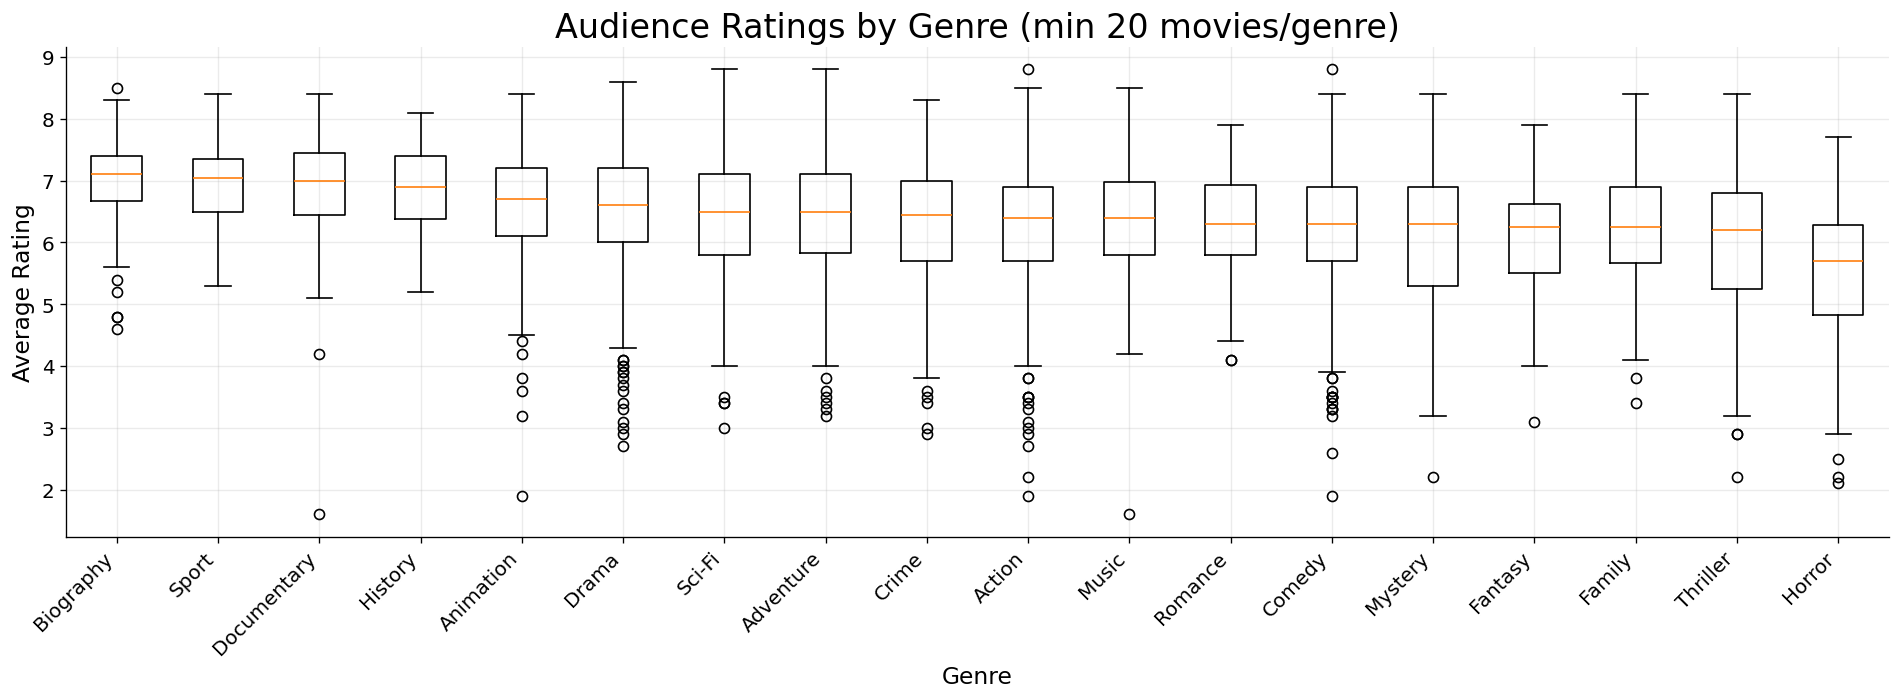

In [135]:
ratings_df = df_g.dropna(subset=["averagerating"]).copy()

# sort genres by median rating 
genre_median = ratings_df.groupby("genre_list")["averagerating"].median().sort_values(ascending=False)
genres_sorted = genre_median.index.tolist()

data_box = [ratings_df.loc[ratings_df["genre_list"] == g, "averagerating"].values for g in genres_sorted]

plt.figure(figsize=(16, 6))
plt.boxplot(
    data_box,
    labels=genres_sorted,
    showfliers=True
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.title("Audience Ratings by Genre (min 20 movies/genre)")
plt.tight_layout()
plt.savefig(out_dir + "ratings_by_genre.png")
plt.show()


## 3.3 Worldwide Gross vs IMdb ratings

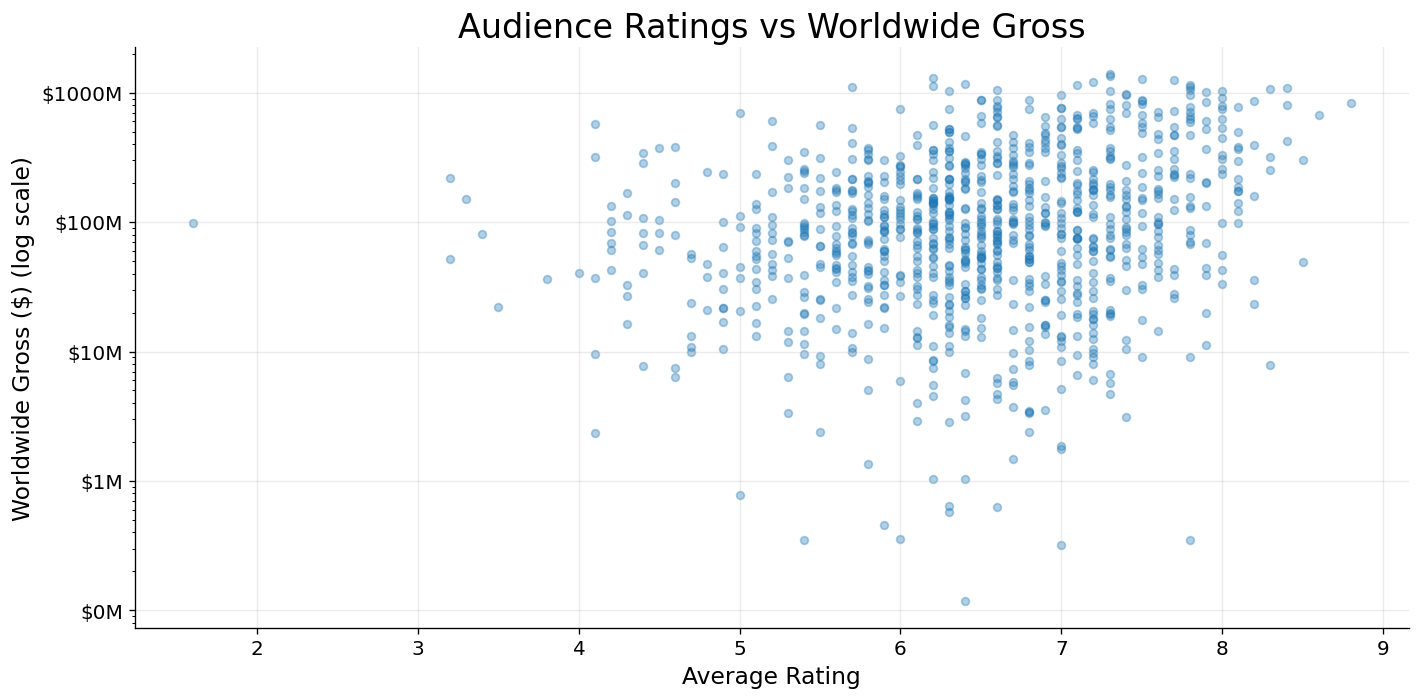

In [136]:
sc_df = merged.dropna(subset=["averagerating", "worldwide_gross_y"]).copy()
sc_df = sc_df[(sc_df["averagerating"] > 0) & (sc_df["worldwide_gross_y"] > 0)]

plt.figure(figsize=(12, 6))
plt.scatter(sc_df["averagerating"], sc_df["worldwide_gross_y"], alpha=0.35, s=22)
plt.yscale("log")
plt.xlabel("Average Rating")
plt.ylabel("Worldwide Gross ($) (log scale)")
plt.title("Audience Ratings vs Worldwide Gross")
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollars_millions))
plt.tight_layout()
plt.savefig(out_dir + "ratings_vs_worldwide_gross.png")
plt.show()

## 3.4 Budget vs Worldwide gross


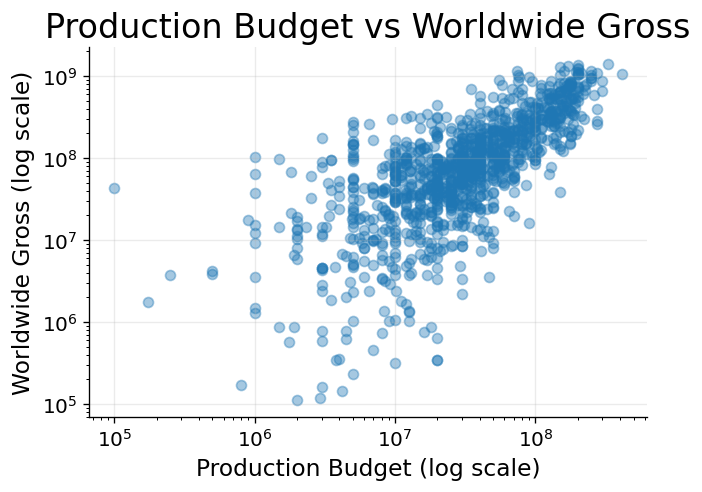

In [137]:
df2 = merged.dropna(subset=["production_budget", "worldwide_gross_y"])
df2 = df2[(df2["production_budget"] > 0) & (df2["worldwide_gross_y"] > 0)]

plt.figure(figsize=(6,4))
plt.scatter(df2["production_budget"], df2["worldwide_gross_y"], alpha=0.4)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Production Budget (log scale)")
plt.ylabel("Worldwide Gross (log scale)")
plt.title("Production Budget vs Worldwide Gross")
plt.grid(True)
plt.savefig(out_dir + "prod_budget_vs_ww_gross.png")
plt.show()


## 3.5 ROI vs Ratings

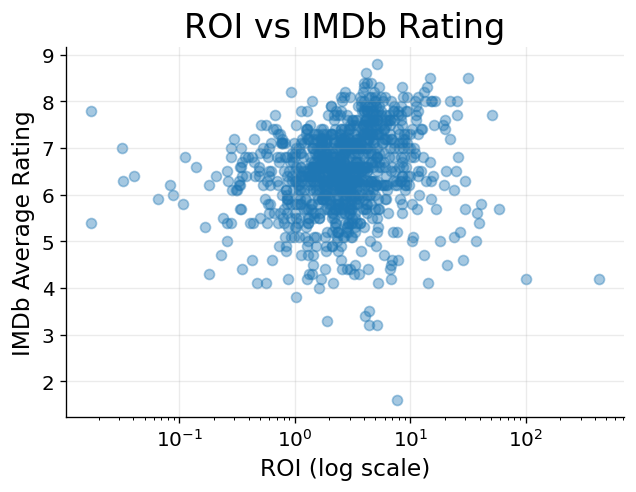

In [138]:
df3 = merged.dropna(subset=["production_budget", "worldwide_gross_y", "averagerating"]).copy()
df3 = df3[(df3["production_budget"] > 0) & (df3["worldwide_gross_y"] > 0)]

df3["roi"] = df3["worldwide_gross_y"] / df3["production_budget"]

plt.figure(figsize=(6,4))
plt.scatter(df3["roi"], df3["averagerating"], alpha=0.4)
plt.xscale("log")
plt.xlabel("ROI (log scale)")
plt.ylabel("IMDb Average Rating")
plt.title("ROI vs IMDb Rating")
plt.grid(True)
plt.savefig(out_dir + "roi_vs_ratings_scatter.png")
plt.show()


## 3.6 Plot the average ROI for each genre

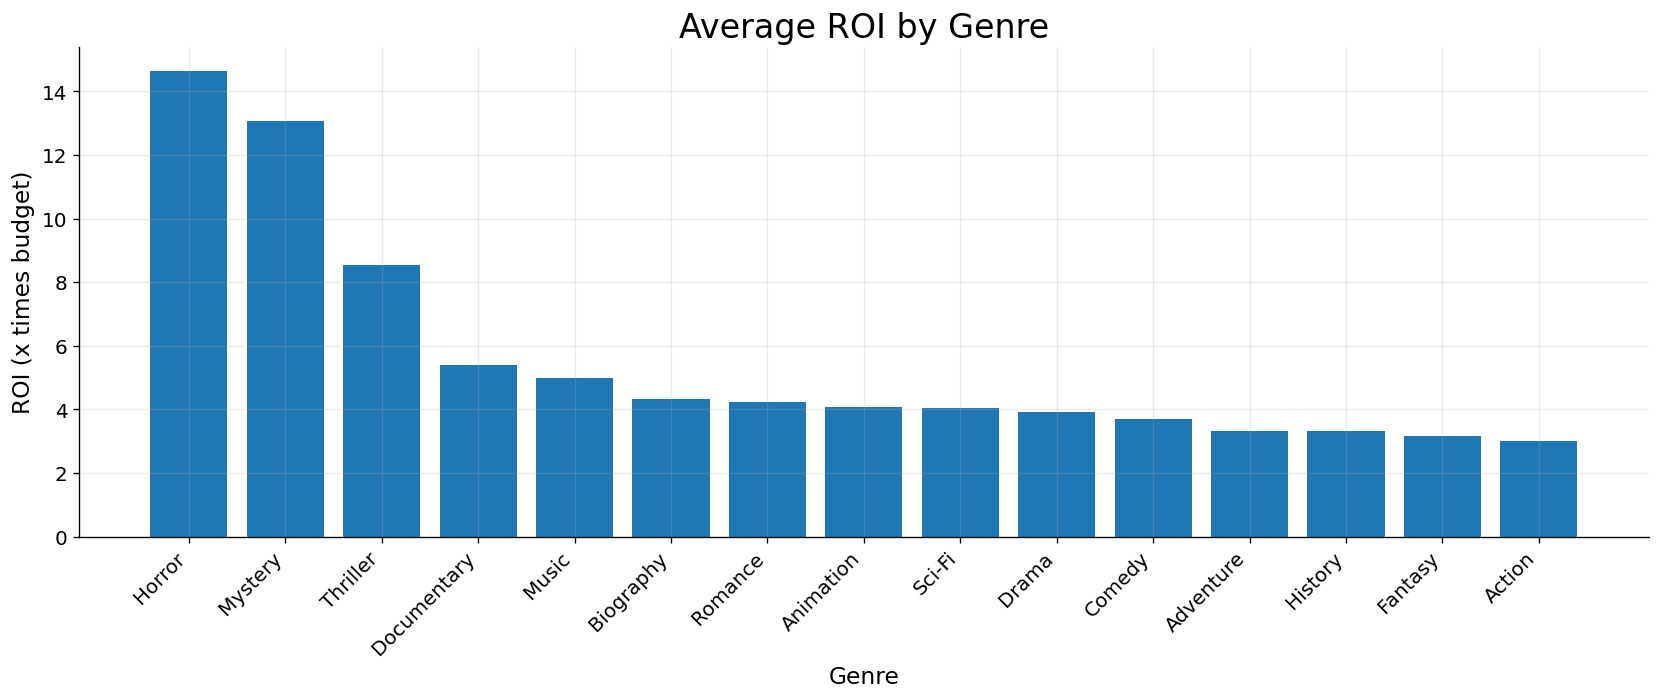

In [139]:
roi_df = df_g.dropna(subset=["production_budget", "worldwide_gross_y"]).copy()
roi_df = roi_df[(roi_df["production_budget"] > 0) & (roi_df["worldwide_gross_y"] > 0)]

roi_df["roi"] = roi_df["worldwide_gross_y"] / roi_df["production_budget"]

roi_by_genre = roi_df.groupby("genre_list")["roi"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(14, 6))
plt.bar(roi_by_genre.index, roi_by_genre.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("ROI (x times budget)")
plt.title("Average ROI by Genre")
plt.tight_layout()
plt.savefig(out_dir + "avg_roi_by_genre.png")
plt.show()

## 3.7 Plot the revenue for each genre 

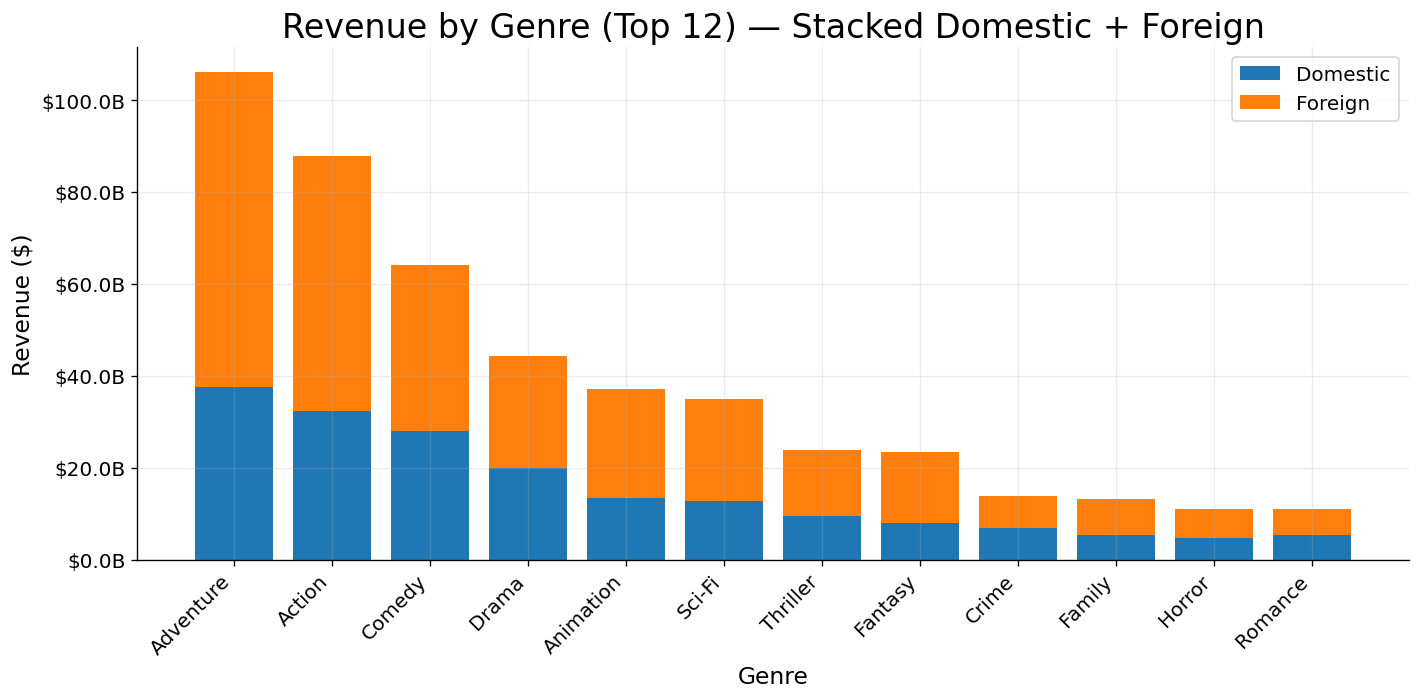

In [140]:
rev_df = df_g.dropna(subset=["domestic_gross_y", "foreign_gross", "worldwide_gross_y"]).copy()
rev_df = rev_df[(rev_df["domestic_gross_y"] >= 0) & (rev_df["foreign_gross"] >= 0) & (rev_df["worldwide_gross_y"] >= 0)]

genre_revenue = rev_df.groupby("genre_list").agg(
    domestic=("domestic_gross_y", "sum"),
    foreign=("foreign_gross", "sum"),
    worldwide=("worldwide_gross_y", "sum")
).sort_values("worldwide", ascending=False)

# take top 'N' genres for readability
TOP_N = 12
genre_revenue = genre_revenue.head(TOP_N)

x = np.arange(len(genre_revenue.index))
dom = genre_revenue["domestic"].values
forg = genre_revenue["foreign"].values  # stacked to reach worldwide

plt.figure(figsize=(12, 6))
plt.bar(x, dom, label="Domestic")
plt.bar(x, forg, bottom=dom, label="Foreign")

plt.xticks(x, genre_revenue.index, rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Revenue ($)")
plt.title(f"Revenue by Genre (Top {TOP_N}) — Stacked Domestic + Foreign")
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollars_billions))
plt.legend()
plt.tight_layout()
plt.savefig(out_dir + "revenue_by_genre.png")
plt.show()


## 3.8 Plot average world wide revenue for movies released in each month

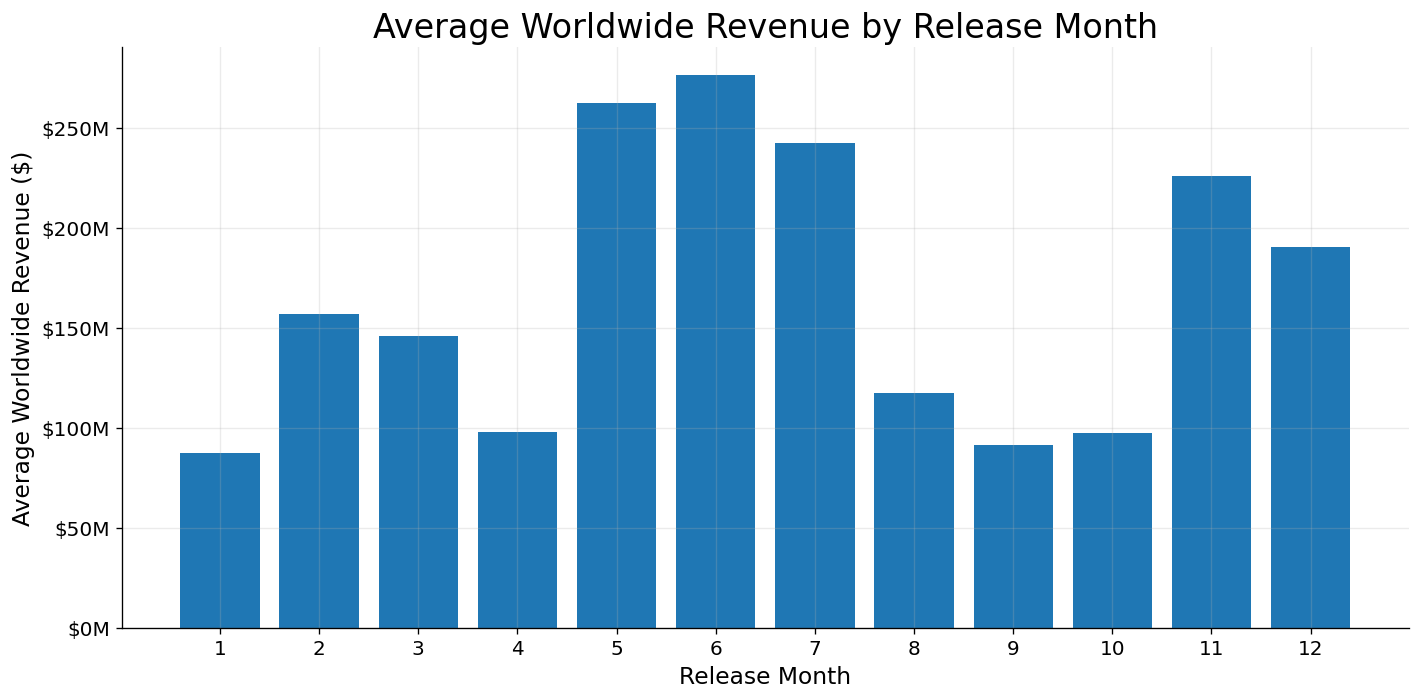

In [141]:
# pick gross columns
gross_pref = "worldwide_gross_y"
gross_fallback = "worldwide_gross_x" if "worldwide_gross_x" in merged.columns else None

# build base month data from release_date
month_base = merged[["release_date"]].copy()
month_base["release_dt"] = pd.to_datetime(month_base["release_date"], errors="coerce")
month_base = month_base.dropna(subset=["release_dt"])
month_base["release_month"] = month_base["release_dt"].dt.month

# try first gross first
month_df = month_base.join(merged[gross_pref].rename("gross"))
month_df["gross"] = pd.to_numeric(month_df["gross"], errors="coerce")
month_df = month_df.dropna(subset=["gross"])
month_df = month_df[month_df["gross"] > 0]

months_present = month_df["release_month"].nunique()
used_col = gross_pref

# if data missing, fall back to budgets dataset gross
if months_present <= 2 and gross_fallback is not None:
    month_df = month_base.join(merged[gross_fallback].rename("gross"))
    month_df["gross"] = pd.to_numeric(month_df["gross"], errors="coerce")
    month_df = month_df.dropna(subset=["gross"])
    month_df = month_df[month_df["gross"] > 0]
    used_col = gross_fallback

# compute monthly averages show all months & fill missing with 0
month_avg = (
    month_df.groupby("release_month")["gross"]
    .mean()
    .reindex(range(1, 13), fill_value=0)
)

plt.figure(figsize=(12, 6))
plt.bar(month_avg.index, month_avg.values)
plt.xlabel("Release Month")
plt.ylabel("Average Worldwide Revenue ($)")
plt.title(f"Average Worldwide Revenue by Release Month")
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollars_millions))
plt.xticks(range(1, 13))
plt.tight_layout()
plt.savefig(out_dir + "avg_worldwide_revenue_by_month.png")
plt.show()

# 4. Conclusions & Key Findings

1. High ratings ≠ high revenue. Audience ratings and worldwide gross show only a weak relationship. This simply great reviews don’t guarantee box office success. This is because commercial performance is driven more by distribution, marketing, franchise power, and release timing other than by ratings alone.

2. Certain genres consistently outperform financially.
A small set of genres delivers the strongest returns on investment. These genres combine scalable audiences with predictable demand, making them lo

3. Release timing materially affects revenue.
Average worldwide revenue varies significantly by release month. Peak months which are usually major holidays and summer windows outperform off-peak months greatly. This confirms that when a film is released can be as important as what film is released.

4. International markets drive the majority of revenue.
Foreign gross often exceeds domestic gross for top-performing genres and titles. This indicates that global appeal and international distribution strategy are critical to maximizing returns. Also global reach may mean having the film scripted in english or atleast offer english subtitles.

5. ROI highlights capital efficiency, not just raw revenue.
Big-budget blockbusters dominate absolute revenue, but ROI analysis shows that mid-budget films in the right genres can outperform in capital efficiency. 
